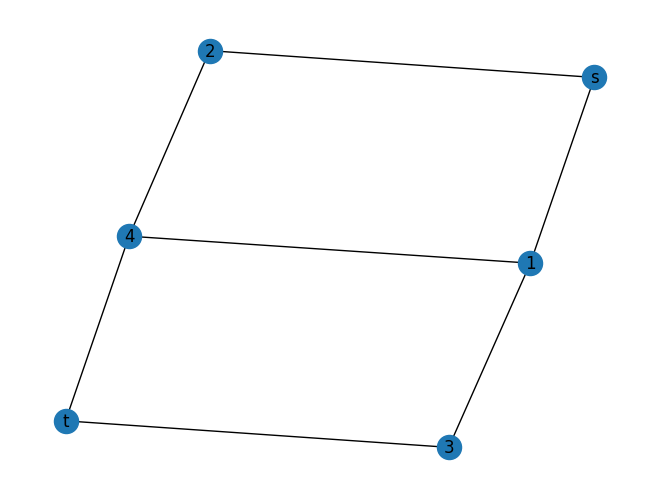

In [132]:
import networkx as nx

graph = nx.Graph()
start_end = ('s','t')
graph_nodes = [1,2,3,4]
graph_edges = [(start_end[0],1),(start_end[0],2),(1,3),(1,4),(2,4),(3,start_end[1]),(4,start_end[1])]

graph.add_nodes_from([start_end[0],start_end[1]] + graph_nodes)
graph.add_edges_from(graph_edges)

nx.draw(graph, with_labels = True)

### Problem 1
#### Problem definition
Assume that forming a path connecting s and t leads to a reward of \$100. Then, compute the
Shapley value associated with the agents in $\{1,2,...,n\}$ as a fair way to distribute that reward among
the agents in $\{1,2,...,n\}$, which in particular encourages cooperation.


In [133]:
from math import factorial
from itertools import combinations

#Function to generate the powerset of a list of elements
def powerset(list: list):
    subsets = [frozenset(j) for i in range(len(list) + 1) for j in combinations(list, i)]
    return subsets

#Function to check if there exists a path between two nodes in a graph
#We create a copy of the graph in order to prune it and left the original one without updates
#After the pruning we check if there exists a path between source node and destination one.
def exists_path_between_nodes(graph:nx.Graph,nodes:frozenset):
  pruned = graph.copy()
  pruned.remove_nodes_from(frozenset(graph.nodes).difference(nodes).difference(frozenset([start_end[0],start_end[1]])))
  return nx.has_path(pruned,start_end[0],start_end[1])

#Function to compute the characteristic function of a coalition.
#Exactly, we assign 100 to a coalition if exists a path that links source node to destination node.
#Otherwise, we assign 0.
def exam_characteristic_function(graph: nx.Graph, coalition: frozenset):
    return 100 if exists_path_between_nodes(graph, coalition) else 0

In [134]:
g_nodes = graph_nodes.copy()

In [135]:
def get_characteristic_function(graph, graph_nodes: frozenset, coalition, check_path, characteristic_function):
    #Check if the characteristic function for the current coalition has already been computed
    if coalition in characteristic_function:
        return

    #Compute the characteristic function value for the current coalition
    characteristic_function[coalition] = exam_characteristic_function(graph, coalition) if check_path else 100
    #Update check_path based on the computed characterisc value
    check_path = False if characteristic_function[coalition] == 100 else True
    #Generate supersets of the by adding one node at a time
    graph_nodes_without_coalition = graph_nodes.difference(coalition)
    supersets = [coalition.union([j]) for j in graph_nodes_without_coalition]
    #Recursively compute characteristic functions for supersets
    for c in supersets:
        get_characteristic_function(graph, graph_nodes, c, check_path, characteristic_function)


characteristic_function = {}
get_characteristic_function(graph, frozenset(g_nodes), frozenset([]), True, characteristic_function)
print("Characteristic function")
for key, value in characteristic_function.items():
    print(f"{list(key)}: {value}")

Characteristic function
[]: 0
[1]: 0
[1, 2]: 0
[1, 2, 3]: 100
[1, 2, 3, 4]: 100
[1, 2, 4]: 100
[1, 3]: 100
[1, 3, 4]: 100
[1, 4]: 100
[2]: 0
[2, 3]: 0
[2, 3, 4]: 100
[2, 4]: 100
[3]: 0
[3, 4]: 0
[4]: 0


In [136]:
#Function to compute Shapley Value for one player.
def shapley_value(player, characteristic_function):
    player_list = max(characteristic_function) #List of all players
    player = set([player]) #Convert the player into a set
    N = len(player_list) #Total number of players
    coalitions = powerset(player_list) #Generate all possible coalitions
    shapley_val = 0
    for coalition in coalitions:
        if len(coalition) != 0: #Exclude the empty coalition
            S = len(coalition) #Size of the coalition
            #Calculate the marginal contribution of the player to the coalition
            marginal_contribution = characteristic_function[coalition] - (characteristic_function[coalition - player] if len(coalition - player) > 0 else 0)
            #Calculate the Shapley value contribution of the player
            shapley_val += ((factorial(N - S) * factorial(S - 1)) / factorial(N)) * marginal_contribution
    return shapley_val

#Function to compute Shapley values for all players.
def shapley(characteristic_function):
    return {player: shapley_value(player, characteristic_function) for player in max(characteristic_function)}

print("** Shapley values **")
shapley_values = shapley(characteristic_function).items()
for key, value in shapley_values:
    print(f"Player {key} -> {value:.2f}")

** Shapley values **
Player 1 -> 33.33
Player 2 -> 16.67
Player 3 -> 16.67
Player 4 -> 33.33


### Problem 2
#### Problem definition
Assume that each agent in $\{1,2…,n\}$ might freely decide whether to provide her/his contribution to connect $s$ and $t$. Assume, in particular, that each agent is willing to contribute only if at most two of her/his neighbours do so. Then, check whether the resulting setting admits a pure Nash equilibrium and compute one, if any.


In [137]:
#Function to check if a given action profile is a Nash equilibrium in the given graph
def check_nash_equilibrium(graph, players, action_profile: dict):
    #Iterate over each player
    for player in players:
        sum_ns = 0
        #Iterate over each neighbor of the player
        for neighbor in graph.neighbors(player):
              #Count the number of neighbors taking action 'y'
              if action_profile[neighbor] == "y":
                sum_ns += 1
        #Check the conditions for Nash equilbrium for the current player
        if action_profile[player] == 'n' and sum_ns <= 2:
          return False
        if action_profile[player] == 'y' and sum_ns > 2:
          return False
    #It returns true only if all players satisfy the Nash equilibrium condition.
    return True

#Function to recursively build an action profile and check if find a Nash equilibrium in the given graph.
def find_nash_equilibrium(graph, players: list, action_profile: dict, i=0):
    #Iterate over both possible actions for the current player
    for c in range(2):
        c2 = ""
        c2 = "y" if c == 1 else "n"
        #Assign the action to the current player
        action_profile[players[i]] = c2
        #If all players have been assigned an action, check if it's a Nash equilibrium
        if i == len(players) - 1:
            if check_nash_equilibrium(graph, players, action_profile):
                return action_profile
        #If not all players have been assigned an action, recursively build an action profile.
        elif find_nash_equilibrium(graph, players, action_profile, i + 1) is not None:
            return action_profile
    return None

In [138]:
# NORMAL VERSION #
#In this scenario, we define an action profile statically, assuming that at the beginning only source node and destination node contributes.
#We define all the others with the function implemented and described before (find_nash_equilibrium)
import time
start_time=time.time()
equilibrium = find_nash_equilibrium(graph, g_nodes,{start_end[0]: 'y', start_end[1]: 'y'})
end_time = time.time()
print(f"Execution time {end_time-start_time}")
normal_time_1 = end_time-start_time

print()
print(equilibrium)

if equilibrium is not None:
    print("N.E found:")
    for key, value in equilibrium.items():
        if key not in start_end:
          print(f"Player {key} {'contributes' if value=='y' else 'does not contribute'}")
else:
    print("N.E not found")

Execution time 0.0001380443572998047

{'s': 'y', 't': 'y', 1: 'n', 2: 'y', 3: 'y', 4: 'y'}
N.E found:
Player 1 does not contribute
Player 2 contributes
Player 3 contributes
Player 4 contributes


**Observation**


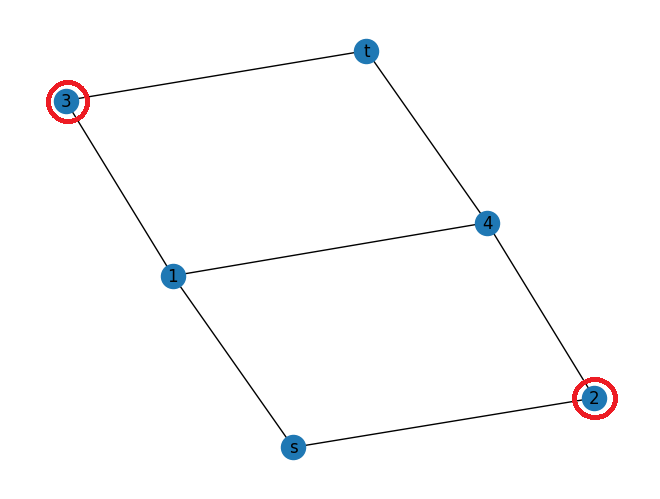

In order to decrease the execution time of our function, we understood that [
$\forall$ v $\in$ V $\quad$ $\mid$ $\quad$ $\text{deg}(v)$ $\leq$ 2
]
always contributes. So, we decided to implement a function that allows us to construct the initial action profile dynamically, instead of starting with 's' and 't' that contributes and determine the states of all the others.
The action profile is built setting 'y' to all the nodes that has degree $\leq$ 2 and subsequently we find the Nash equilibrium.

In [139]:
#Function to build an initial action profile for the players based on graph connectivity
def build_action_profile(graph, players, add):
    #Initialize the action profile with default action 'y' for players with degree <= 2
    action_profile = {player: 'y' for player in players if graph.degree(player) <= 2}
    #Optionally, add source and destination nodes to the action profile
    if add:
        action_profile.update({start_end[0]: 'y', start_end[1]: 'y'})
    #Identify players not yet included in the action profile
    new_players = [p for p in players if p not in action_profile]
    #Return the action profile and the updated list of players
    return action_profile, new_players if new_players else players.copy()

In [140]:
#At this time, instead of having only source and destination node that contributes at the beginning, we define dinamycally the initial action profile.
action_profile,new_g_nodes = build_action_profile(graph,g_nodes,True)

In [141]:
import time
start_time=time.time()
equilibrium = find_nash_equilibrium(graph, new_g_nodes,action_profile)
end_time = time.time()
print(f"Execution time {end_time-start_time}")
optimized_time_1 = end_time-start_time

print()
print(equilibrium)

if equilibrium is not None:
    print("N.E found:")
    for key, value in equilibrium.items():
        if key not in start_end:
          print(f"Player {key} {'contributes' if value=='y' else 'does not contribute'}")
else:
    print("N.E not found")

Execution time 7.534027099609375e-05

{2: 'y', 3: 'y', 's': 'y', 't': 'y', 1: 'n', 4: 'y'}
N.E found:
Player 2 contributes
Player 3 contributes
Player 1 does not contribute
Player 4 contributes


**Observation (2)**

We can notice that starting with the initial action profile defined by our function we take less time to find the nash equilibrium.

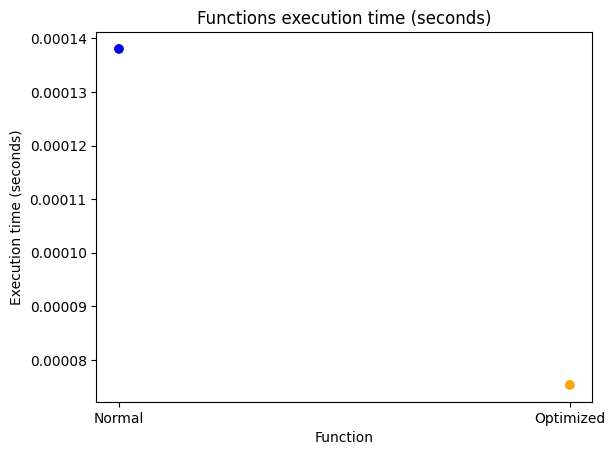

In [142]:
import matplotlib.pyplot as plt
labels = ['Normal', 'Optimized']
times = [normal_time_1, optimized_time_1]

plt.scatter(labels, times, color=['blue', 'orange'])
plt.xlabel('Function')
plt.ylabel('Execution time (seconds)')
plt.title('Functions execution time (seconds)')
plt.show()

**Observation (3)**

To better demonstrate that defining the initial action profile with our function takes less execution time we decided to create 10 random graphs, with a number of nodes ranging from 5 to 15 and a probability of 25% connectivity and test execution times with a dynamically defined action profile and start by defining only the source and destination node as contributors.


One of founded equilibrium:
N.E found:
Player 0 does not contribute
Player 1 contributes
Player 2 contributes
Player 3 contributes
Player 4 contributes
Player 5 contributes
Player 6 contributes
Player 7 contributes
Player 8 does not contribute
Player 9 contributes


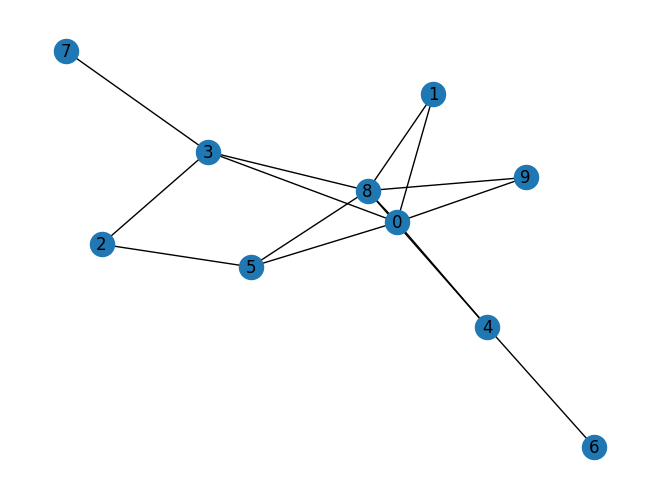

In [143]:
from random import randint,uniform
import time

normal_times = []
optimized_times = []
equilibriums = []
random_graphs = []

for i in range(5,16):
  random_graph = nx.fast_gnp_random_graph(i,0.25)
  random_graphs.append(random_graph)

  nodes_list = list(random_graph.nodes())
  action_profile_random,random_nodes = build_action_profile(random_graph,nodes_list,False)

  optimized_start_time = time.time()

  equilibrium = find_nash_equilibrium(random_graph, random_nodes ,action_profile_random)

  optimized_end_time = time.time()

  optimized_times.append(optimized_end_time-optimized_start_time)

  normal_start_time=time.time()
  equilibrium = find_nash_equilibrium(random_graph,nodes_list,{})
  normal_end_time=time.time()

  normal_times.append(normal_end_time-normal_start_time)
  equilibriums.append(equilibrium)
  del random_graph


print("One of founded equilibrium:")
if equilibriums[5] is not None:
    print("N.E found:")
    for key, value in equilibriums[5].items():
        if key not in start_end:
          print(f"Player {key} {'contributes' if value=='y' else 'does not contribute'}")
else:
    print("N.E not found")

nx.draw(random_graphs[5], with_labels = True)

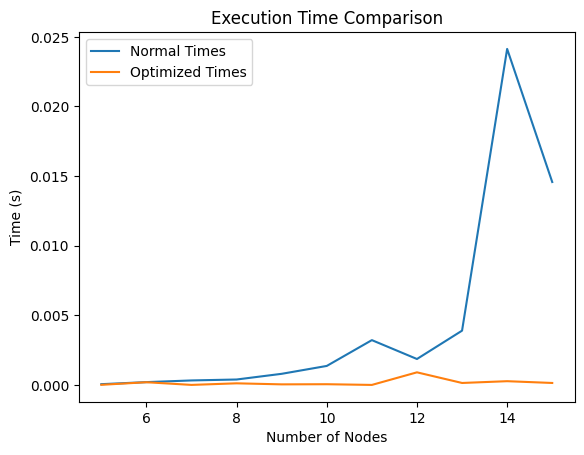

In [144]:
import matplotlib.pyplot as plt

# Plot dei tempi normali e ottimizzati
plt.plot(range(5, 16), normal_times, label='Normal Times')
plt.plot(range(5, 16), optimized_times, label='Optimized Times')

plt.xlabel('Number of Nodes')
plt.ylabel('Time (s)')
plt.title('Execution Time Comparison')
plt.legend()
plt.show()


#### Problem 3
Taking into account the fact that the graph has bounded treewidth, we can now leverage Courcelle's theorem, which asserts that any problem on graphs expressible in Monadic Second Order Logic (MSO) can be solved in linear time on graphs with bounded treewidth.

By translating point (2) into MSO we can demonstrate that there is a linear algorithm that can solve this problem on the graphs on the delimited trees

### Sets definition
$N:$ \{$v$ $\in$ $N$ $\to$ $\exists$ $x$,$y$,$z$ $\in$ $\Gamma($v$)$ $\land$ ($x$ $\neq$ $y$ $\neq$ $z$) $\land$ ($x$ $\in$ $Y$ $\land$ $y$ $\in$ $Y$ $\land$ $z$ $\in$ $Y$)\}

$Y$: \{$v$ $\in$ $Y$ $\to$ ((($\exists$ $x$ $\in$ $\Gamma($v$)$ $\land$ $x$ $\in$ $Y$) $\lor$ ($\exists$ $x$,$y$ $\in$ $\Gamma($v$)$ $\land$ $x$ $\neq$ $y$ $\land$ ($x$ $\in$ $Y$ $\land$ $y$ $\in$ $Y$))) $\land$ ($\nexists$ $x$,$y$,$z$ $\in$ $\Gamma($v$)$ $\land$ ($x$ $\neq$ $y$ $\neq$ $z$) $\land$ ($x$ $\in$ $Y$ $\land$ $y$ $\in$ $Y$ $\land$ $z$ $\in$ $Y$)))\}



*   $N$ set of nodes that doesn't contribute to the equilibrium.
*   $Y$ set of nodes that contributes to the equilibrium.
*   $\Gamma($v$)$ Is the neighbourhood of v

### Conditions

($\exists$ N,Y) [ ( $\forall$ v (N(v)  $\lor$  Y(v))

$\land$ ($\forall$ v (N(v) $\Rightarrow$ ( $\neg$ Y(v))))

$\land$ ($\forall$ v (Y(v) $\Rightarrow$ ( $\neg$ N(v))))

$\land$ ($\forall$ v ( N(v) $\Rightarrow$ $\exists$ x,y,z $\in$ $\Gamma(v)$$\land$ (Y(x) $\land$ Y(y) $\land$ Y(z))))

$\land$($\forall$ v (Y(v) $\Rightarrow$ ($\exists$ x $\in$ $\Gamma(v)$ $\land$ (Y(x))

$\lor$($\exists$ x,y $\in$ $\Gamma(v)$ $\land$ (Y(x) $\land$ Y(y))))

$\land$($\nexists$ x,y,z $\in$ $\Gamma(v)$ $\land$ (Y(x) $\land$ Y(y) $\land$ Y(z)))\)) ]










### Problem 4
#### Problem definition
Assume that agent $i$ in $\{1,2,...,n\}$ has some internal utility – say $i * 10\$$ – for being selected in a path
connecting $s$ and $t$, and that s/he might cheat in declaring a different utility. Assume moreover that
the goal is to form a path with the maximum overall possible utility, and compute a payment scheme
that provides incentives to truthfully report such utility values.


In [145]:
paths = set(map(frozenset,nx.all_simple_paths(graph,start_end[0],start_end[1])))
print(paths)

{frozenset({1, 's', 3, 't'}), frozenset({1, 's', 't', 4}), frozenset({'s', 2, 4, 't'}), frozenset({1, 2, 3, 4, 't', 's'})}


In [146]:
# Function to calculate utilities for each node
def utilities(nodes,who_cheats,cheater_cost=0):
    uti={}
    for node in nodes:
      #This part, is only to proove that our VCG mechanism take care about truthfulness, and to show a scenario where agent tries to lie.
      if node == who_cheats:
        uti[node] = cheater_cost
      else:
        uti[node] = node*10
    return uti

#Function to find the best result among all given paths
def find_best_result(paths,uti):
    best_result = 0
    best_path = []

    for path in paths:
        result=0
        for node in path:
          if node not in start_end:
            result+=uti[node]
        #result = sum(utility(node,cost) for node in path if node not in start_end)
        if result > best_result:
            best_result = result
            best_path = path
    return best_result, best_path

#Function to find the best result where a specified player doesn't appear in the paths.
def find_best_result_excluding_player(paths, excluded_player,uti):
    best_result = 0
    for path in paths:
        if excluded_player not in path:
            result=0
            for node in path:
              if node not in start_end:
                result+=uti[node]
            best_result = max(result, best_result)
    return best_result
#Our VCG Mechanism Interface
def estimate_payment(best_result, best_path, player,uti):
    result_player = best_result - uti[player] if player in best_path else best_result
    result_excluding_player = find_best_result_excluding_player(paths, player,uti)
    return result_excluding_player - result_player



**1st Scenario**

We assume that neither of our agent try to the declared false and cheats over the mechanism.


In [147]:
u = utilities(g_nodes,None)
best_result, best_path = find_best_result(paths,u)
print("Payments:")
for node in g_nodes:
    print(f"Payment of player {node}: {estimate_payment(best_result, best_path, node,u)}")

print("*"*len("Payment of player # :    "))


Payments:
Payment of player 1: -30
Payment of player 2: -30
Payment of player 3: -10
Payment of player 4: -20
*************************


**2nd Scenario**


For illustration purposes, each agent in different round will try to cheat, declaring a fake utility of 100.


In [148]:
for node in g_nodes:
  print(f"Now is cheating {node}")
  u = utilities(g_nodes,node,100)
  best_result, best_path = find_best_result(paths,u)
  print("Payments:")
  for node in g_nodes:
      print(f"Payment of player {node}: {estimate_payment(best_result, best_path, node,u)}")

  print("*"*len("Payment of player # :    "))

Now is cheating 1
Payments:
Payment of player 1: -30
Payment of player 2: -30
Payment of player 3: -20
Payment of player 4: -20
*************************
Now is cheating 2
Payments:
Payment of player 1: -30
Payment of player 2: -30
Payment of player 3: -10
Payment of player 4: -100
*************************
Now is cheating 3
Payments:
Payment of player 1: -100
Payment of player 2: -40
Payment of player 3: -10
Payment of player 4: -20
*************************
Now is cheating 4
Payments:
Payment of player 1: -30
Payment of player 2: -30
Payment of player 3: -10
Payment of player 4: -20
*************************


**Observation**

We can see that, even if a player tries to lie, he will not improve his situation and will remain as he is, on the contrary, he will probably benefit some other player.

In [149]:
from tabulate import tabulate

data = [
    ["1", "-30🦹", "-30👤", "-20👤", "-20👤"],
    ["2", "-30👤", "-30🦹", "-10👤", "-100👤"],
    ["3", "-100👤", "-40👤", "-10🦹", "-20👤"],
    ["4", "-30👤", "-30👤", "-10👤", "-20🦹"]
]

headers = ["Cheater 🦹", "Player 1 👤", "Player 2 👤", "Player 3 👤", "Player 4 👤"]

print(tabulate(data, headers=headers))


  Cheater 🦹  Player 1 👤    Player 2 👤    Player 3 👤    Player 4 👤
------------  -------------  -------------  -------------  -------------
           1  -30🦹          -30👤          -20👤          -20👤
           2  -30👤          -30🦹          -10👤          -100👤
           3  -100👤         -40👤          -10🦹          -20👤
           4  -30👤          -30👤          -10👤          -20🦹
